# Running quantum circuits on QPU devices

In this tutorial we show how to run circuits on QPU devices. We can run our circuit on both the superconducting machine from Rigetti and the ion-trap machine provided by IonQ. As shown below, one can seamlessly swap between different devices without any modifications to the circuit definition, by just re-defining the device object. We also show how to recover results using the unique ARN associated with every task. This tool is useful in order to deal with potential delays if your quantum task sits in the queue for some time waiting for execution. 

In [1]:
import string

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask

## Supported gate sets by different devices

First, let us check out the gate set currently supported by our SDK. Note that the QPU devices only support a subset of these gates.

In [2]:
# print all available gates currently available within SDK
gate_set = [attr for attr in dir(Gate) if attr[0] in string.ascii_uppercase]
print("Gate set supported by SDK:\n", gate_set)
print()


def get_supported_gates(divice_name: str) -> list:
    device = AwsDevice(divice_name)
    ret = device.properties.action["braket.ir.jaqcd.program"].supportedOperations
    return ret


# the Rigetti device
gate_set = get_supported_gates("arn:aws:braket:::device/qpu/rigetti/Aspen-11")
print("Gate set supported by the Rigetti device:\n", gate_set)
print()

# the IonQ device
gate_set = get_supported_gates("arn:aws:braket:::device/qpu/ionq/ionQdevice")
print("Gate set supported by the IonQ device:\n", gate_set)
print()

# the Oxford Quantum Circuits (OQC) device
gate_set = get_supported_gates("arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy")
print("Gate set supported by the OQC device:\n", gate_set)


Gate set supported by SDK:
 ['CCNot', 'CNot', 'CPhaseShift', 'CPhaseShift00', 'CPhaseShift01', 'CPhaseShift10', 'CSwap', 'CV', 'CY', 'CZ', 'ECR', 'H', 'I', 'ISwap', 'PSwap', 'PhaseShift', 'Rx', 'Ry', 'Rz', 'S', 'Si', 'Swap', 'T', 'Ti', 'Unitary', 'V', 'Vi', 'X', 'XX', 'XY', 'Y', 'YY', 'Z', 'ZZ']

Gate set supported by the Rigetti device:
 ['cz', 'xy', 'ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'h', 'i', 'iswap', 'phaseshift', 'pswap', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'x', 'y', 'z', 'start_verbatim_box', 'end_verbatim_box']

Gate set supported by the IonQ device:
 ['x', 'y', 'z', 'rx', 'ry', 'rz', 'h', 'cnot', 's', 'si', 't', 'ti', 'v', 'vi', 'xx', 'yy', 'zz', 'swap', 'i']

Gate set supported by the OQC device:
 ['ccnot', 'cnot', 'cphaseshift', 'cswap', 'cy', 'cz', 'h', 'i', 'phaseshift', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'v', 'vi', 'x', 'y', 'z', 'ecr', 'start_verbatim_box', 'end_verbatim_box']


## Prepare Bell State

Goal: Prepare maximally entangled Bell state: 
$$\left|0,0\right> \rightarrow \left|\mathrm{Bell}\right> = \frac{1}{\sqrt{2}}\left(\left|0,0\right> + \left|1,1\right>\right).$$

To this end, we build and run the following circuit using a single-qubit Hadamard gate (denoted as ```H```) acting on the first qubit followed by a two-qubit ```CNOT``` gate: 
<div align="center">
<img src="bell_circuit.png" width="500"/>
</div>
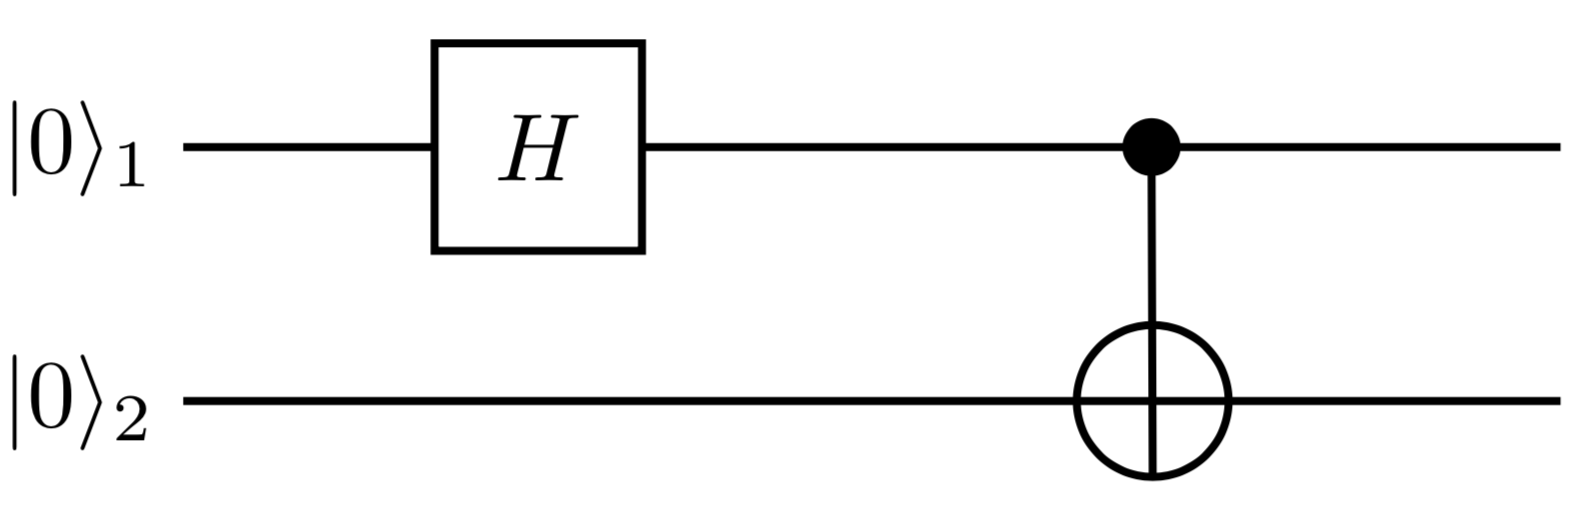

### Setup Circuit

In [3]:
bell = Circuit().h(0).cnot(0, 1)
print(bell)

T  : |0|1|
          
q0 : -H-C-
        | 
q1 : ---X-

T  : |0|1|


### Local Simulator
First we run our circuit locally, using an exact state-vector simulator. This local simulator is the preferred choice for fast experiments with low to intermediate qubit numbers ($N<20-25$) and essentially unlimited circuit depth. 

In [4]:
device = LocalSimulator()

# run circuit (execute single TASK)
result = device.run(bell, shots=1000).result()

# get measurement shots
counts = result.measurement_counts
print(counts)

Counter({'00': 514, '11': 486})


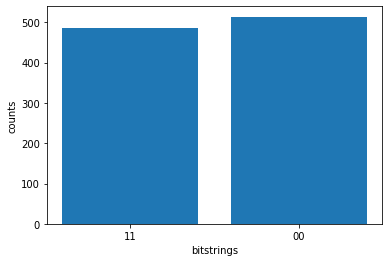

In [5]:
plt.bar(counts.keys(), counts.values())
plt.xlabel("bitstrings")
plt.ylabel("counts");


### Quantum Hardware

#### Rigetti

Next we submit our circuit to the superconducting quantum chip provided by Rigetti. Depending on our position in the queue, we may have to wait for some time till our circuit is actually run. However, thanks to asynchronous execution, we can always come back and recover the results by providing the unique ID associated with every task. 

In [6]:
rigetti = AwsDevice("arn:aws:braket:::device/qpu/rigetti/Aspen-11")
assert rigetti.status == 'ONLINE'

# create a clean circuit with no result type attached.(This is because some result types are only supported when shots=0)
bell = Circuit().h(0).cnot(0, 1)

# add the Z \otimes Z expectation value
bell.expectation(Observable.Z() @ Observable.Z(), target=[0, 1])

# run circuit
rigetti_task = rigetti.run(bell, shots=1000)

# get id and status of submitted task
rigetti_task_id = rigetti_task.id
rigetti_status = rigetti_task.state()

print("ID of task:", rigetti_task_id)
print("Status of task:", rigetti_status)


ID of task: arn:aws:braket:us-west-1:901160528933:quantum-task/51ab948c-32b8-4494-be79-fda37cbe7167
Status of task: CREATED


The task is submitted and we can regularly (or irregularly) check the status of this task by executing the following cell. You may easily build logic around this query to wait for this task to complete before your code proceeds. 

In [7]:
status = rigetti_task.state()
print("Status of task:", status)


Status of task: RUNNING


#### IonQ

Next, we submit our example Bell state circuit to IonQ. This task may not readily be executed but enter a queue for this specific machine. While we can interrupt our kernel (and work on something else), we can always recover our results using the unique ID of this task.

In [8]:
ionq = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
assert ionq.status == 'ONLINE'

# run circuit
ionq_task = ionq.run(bell, shots=1000)

# get id and status of submitted task
ionq_task_id = ionq_task.id
ionq_status = ionq_task.state()

print("ID of task:", ionq_task_id)
print("Status of task:", ionq_status)


ID of task: arn:aws:braket:us-east-1:901160528933:quantum-task/00b5ca2f-0c9e-4966-a2d2-129f24305627
Status of task: CREATED


In [9]:
status = ionq_task.state()
print("Status of task:", status)


Status of task: CREATED


#### Oxford Quantum Circuits

Finally, we submit our circuit to the superconducting quantum computer provided by Oxford Quantum Circuits (OQC). The task runs asynchronously. We can retrieve the result when the task is completed.

In [10]:
oqc = AwsDevice("arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy")
assert oqc.status == "ONLINE"

# run circuit
oqc_task = oqc.run(bell, shots=1000)

# get id and status of submitted task
oqc_task_id = oqc_task.id
oqc_status = oqc_task.state()

print("ID of task:", oqc_task_id)
print("Status of task:", oqc_status)


ID of task: arn:aws:braket:eu-west-2:901160528933:quantum-task/8d42e3cb-e5d7-47fd-9c09-7d99fa97acfb
Status of task: CREATED


### Task Recovery

By simply grabbing the unique task ID associated with the quantum tasks we have submitted above, we can recover this task at any point in time and (once the status is completed) visualize and analyze the corresponding results. Note that apart from other metadata, you can retrieve the compiled circuit that was actually run on the Rigetti device. More information about the compiling process can be found [here](https://pyquil-docs.rigetti.com/en/v2.22.0/compiler.html#partial). 

Status of task: COMPLETED

1000 shots taken on machine arn:aws:braket:::device/qpu/rigetti/Aspen-11

The compiled circuit is:
DECLARE ro BIT[2]
PRAGMA INITIAL_REWIRING "PARTIAL"
RESET
RZ(pi/2) 13
RX(pi/2) 13
RZ(4.219887182268869) 13
RZ(-pi/2) 14
RX(pi/2) 14
RZ(2.063298124910716) 14
CZ 14 13
RZ(0.4925017981158197) 13
RZ(1.0782945286790775) 14
RX(pi/2) 14
RZ(3*pi/2) 14
MEASURE 14 ro[1]
MEASURE 13 ro[0]

Measurement counts: Counter({'11': 363, '00': 340, '10': 179, '01': 118})


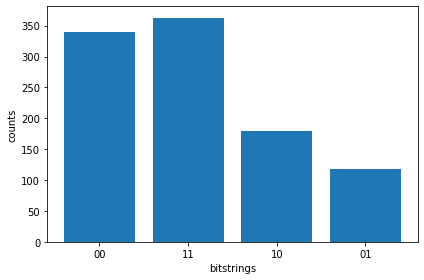

In [11]:
task_load = AwsQuantumTask(arn=rigetti_task_id)
status = task_load.state()
print("Status of task:", status)
print()

# wait for job to complete
# terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
if status == "COMPLETED":
    results = task_load.result()
    # print(results)

    # get all metadata of submitted task
    metadata = task_load.metadata()
    shots = metadata["shots"]
    machine = metadata["deviceArn"]
    print(f"{shots} shots taken on machine {machine}")
    print()

    # get the compiled circuit
    print("The compiled circuit is:")
    print(results.additional_metadata.rigettiMetadata.compiledProgram)

    # get measurement counts
    counts = results.measurement_counts
    print("Measurement counts:", counts)

    # plot results: see effects of noise
    plt.bar(counts.keys(), counts.values())
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.tight_layout()
    # plt.savefig("rigetti.png", dpi=700)

elif status in ["FAILED", "CANCELLED"]:
    print(f"Your task is in terminal status {status}, but has not completed.")

else:
    print(f"Sorry, your task is still {status} and has not been finalized yet.")


Status of task: COMPLETED

1000 shots taken on machine arn:aws:braket:::device/qpu/ionq/ionQdevice

Measurement counts: Counter({'11': 494, '00': 489, '01': 10, '10': 7})


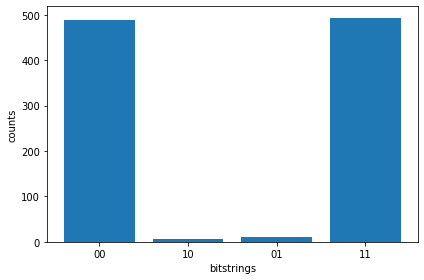

In [14]:
task_load = AwsQuantumTask(arn=ionq_task_id)

status = task_load.state()
print('Status of task:', status)
print()

# wait for job to complete
# terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
if status == 'COMPLETED':
    results = task_load.result()
    # print(results)
    
    # get all metadata of submitted task
    metadata = task_load.metadata()
    shots = metadata["shots"]
    machine = metadata["deviceArn"]
    print(f"{shots} shots taken on machine {machine}")
    print()
    
    # get measurement counts
    counts = results.measurement_counts
    print("Measurement counts:", counts)

    # plot results: see effects of noise
    plt.bar(counts.keys(), counts.values())
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.tight_layout()
    # plt.savefig('bell_ionq.png', dpi=700)
    
elif status in ["FAILED", "CANCELLED"]:
    print(f"Your task is in terminal status {status}, but has not completed.")

else:
    print(f"Sorry, your task is still {status} and has not been finalized yet.")

We have successfully recovered the results associated with the tasks that were queued up for the quantum hardware providers. Because of noise (decoherence) and other imperfections we cannot fully recover the exact results we have seen when using the classical simulator. To deal with that, in the fullness of time we will be able to use error correction techniques. As long as error correction is not available, it is important to benchmark our quantum results using classical simulators, whenever possible. 